In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import solve
from scipy.stats import gaussian_kde
from properscoring import crps_ensemble
from numba import jit
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import warnings
from itertools import product

from scipy import signal

warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from scipy import signal

import numpy as np
from scipy.linalg import svd
from sklearn.linear_model import Ridge
from statsmodels.tsa.seasonal import seasonal_decompose
from properscoring import crps_ensemble
from numba import jit
from bayes_opt import BayesianOptimization

# Clases

## Clase Simulación

In [2]:


class TimeSeriesSimulator:
    """Clase para generar diferentes tipos de series temporales simuladas"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        np.random.seed(random_state)
        
    def _create_date_index(self, n_points, start_date='2000-01-01', freq='MS'):
        """Crea un índice de fechas para la serie temporal"""
        return pd.date_range(start=start_date, periods=n_points, freq=freq)
    
    def generate_ar(self, n_points=300, ar_params=[-0.5], mean=100, std=1, start_date='2000-01-01', freq='MS'):
        """Genera una serie temporal AR (Autoregresiva)"""
        ar = np.r_[1, ar_params]
        ma = [1]
        arma_process = ArmaProcess(ar, ma)
        data = arma_process.generate_sample(nsample=n_points, scale=std) + mean
        dates = self._create_date_index(n_points, start_date, freq)
        return pd.DataFrame({'fecha': dates, 'valor': data})
    
    def generate_ma(self, n_points=300, ma_params=[0.5], mean=100, std=1, start_date='2000-01-01', freq='MS'):
        """Genera una serie temporal MA (Media Móvil)"""
        ar = [1]
        ma = np.r_[1, ma_params]
        arma_process = ArmaProcess(ar, ma)
        data = arma_process.generate_sample(nsample=n_points, scale=std) + mean
        dates = self._create_date_index(n_points, start_date, freq)
        return pd.DataFrame({'fecha': dates, 'valor': data})
    
    def generate_arma(self, n_points=300, ar_params=[-0.5], ma_params=[0.5], mean=100, std=1, start_date='2000-01-01', freq='MS'):
        """Genera una serie temporal ARMA (Autoregresiva y Media Móvil)"""
        ar = np.r_[1, ar_params]
        ma = np.r_[1, ma_params]
        arma_process = ArmaProcess(ar, ma)
        data = arma_process.generate_sample(nsample=n_points, scale=std) + mean
        dates = self._create_date_index(n_points, start_date, freq)
        return pd.DataFrame({'fecha': dates, 'valor': data})
    
    def generate_trend(self, n_points=300, trend_type='linear', slope=0.1, mean=100, noise_std=70, start_date='2000-01-01', freq='MS'):
        """Genera una serie temporal con tendencia"""
        x = np.arange(n_points)
        if trend_type == 'linear':
            trend = mean + slope * x
        elif trend_type == 'exponential':
            trend = mean * np.exp(slope * x)
        elif trend_type == 'quadratic':
            trend = mean + slope * x**2
        
        noise = np.random.normal(0, noise_std, n_points)
        data = trend + noise
        dates = self._create_date_index(n_points, start_date, freq)
        return pd.DataFrame({'fecha': dates, 'valor': data})
    
    def generate_seasonal(self, n_points=300, period=12, amplitude=10, mean=100, noise_std=1, start_date='2000-01-01', freq='MS'):
        """Genera una serie temporal con estacionalidad"""
        x = np.arange(n_points)
        seasonal = amplitude * np.sin(2 * np.pi * x / period)
        noise = np.random.normal(0, noise_std, n_points)
        data = mean + seasonal + noise
        dates = self._create_date_index(n_points, start_date, freq)
        return pd.DataFrame({'fecha': dates, 'valor': data})
    
    def generate_trend_seasonal(self, n_points=300, trend_type='linear', slope=0.1, period=12, amplitude=10, 
                              mean=100, noise_std=1, start_date='2000-01-01', freq='MS'):
        """Genera una serie temporal con tendencia y estacionalidad"""
        # Componente de tendencia
        x = np.arange(n_points)
        if trend_type == 'linear':
            trend = mean + slope * x
        elif trend_type == 'exponential':
            trend = mean * np.exp(slope * x)
        elif trend_type == 'quadratic':
            trend = mean + slope * x**2
            
        # Componente estacional
        seasonal = amplitude * np.sin(2 * np.pi * x / period)
        
        # Ruido
        noise = np.random.normal(0, noise_std, n_points)
        
        # Combinación de componentes
        data = trend + seasonal + noise
        dates = self._create_date_index(n_points, start_date, freq)
        return pd.DataFrame({'fecha': dates, 'valor': data})

    def generate_arima(self, n_points=300, ar_params=[-0.5], ma_params=[0.5], d=2, mean=100, std=1, 
                  start_date='2000-01-01', freq='MS', noise_level=0.1):
        """
        Genera una serie temporal ARIMA con diferenciación d >= 2 y ruido adicional
        
        Parámetros:
        -----------
        n_points : int
            Número de puntos a generar
        ar_params : list
            Parámetros autoregresivos
        ma_params : list
            Parámetros de media móvil
        d : int
            Orden de diferenciación (debe ser >= 2)
        mean : float
            Media de la serie
        std : float
            Desviación estándar del ruido base
        noise_level : float
            Nivel de ruido adicional (como proporción de la desviación estándar)
        """
        if d < 2:
            raise ValueError("El orden de diferenciación (d) debe ser mayor o igual a 2")
        
        # Generamos una serie ARMA
        ar = np.r_[1, ar_params]
        ma = np.r_[1, ma_params]
        arma_process = ArmaProcess(ar, ma)
        
        # Generamos más puntos para compensar la diferenciación
        extra_points = d * 10
        total_points = n_points + extra_points
        
        # Generamos la serie ARMA base
        scale_factor = std / (d * 10)
        arma_data = arma_process.generate_sample(nsample=total_points, scale=scale_factor)
        
        # Aplicamos integración d veces
        integrated_data = arma_data.copy()
        for i in range(d):
            integrated_data = np.cumsum(integrated_data)
            integrated_data = integrated_data - np.mean(integrated_data)
            integrated_data = integrated_data / np.std(integrated_data) * std
        
        # Recortamos los puntos extra
        final_data = integrated_data[extra_points:]
        
        # Añadimos ruido adicional
        noise = np.random.normal(0, std * noise_level, size=n_points)
        final_data = final_data + noise
        
        # Ajustamos la media
        final_data = final_data + mean
        
        dates = self._create_date_index(n_points, start_date, freq)
        return pd.DataFrame({'fecha': dates, 'valor': final_data})

## Clase plotter

In [3]:

class PlotUtils:
    """Utilidades para visualización de resultados"""
    def __init__(self, random_state=42):
        self.random_state = random_state
        np.random.seed(self.random_state)
    
    @staticmethod
    def plot_time_series(df):
        """Grafica la serie temporal"""
        plt.figure(figsize=(12, 6))
        plt.plot(df['fecha'], df['valor'], alpha=0.7, linewidth=1)
        plt.xlabel('Fecha')
        plt.ylabel('Valor')
        plt.title('Serie Temporal')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def plot_comparative_density(self, distributions_dict, y_real):
        """Grafica la densidad de múltiples distribuciones"""
        plt.figure(figsize=(12, 6))
        colors = ['blue', 'red', 'green', 'purple']
        
        for (name, dist), color in zip(distributions_dict.items(), colors):
            density = gaussian_kde(dist)
            x_vals = np.linspace(min(dist), max(dist), 1000)
            y_vals = density(x_vals)
            mean_dist = np.mean(dist)
            
            plt.plot(x_vals, y_vals, color=color, label=f'Densidad {name}')
            plt.axvline(mean_dist, color=color, linestyle='--',
                       label=f'Media {name} = {mean_dist:.2f}')
        
        plt.axvline(y_real, color='black', linestyle='-',
                   label=f'Valor real = {y_real:.2f}')
        plt.xlabel('Valores')
        plt.ylabel('Densidad')
        plt.title('Comparación de Distribuciones Predictivas')
        plt.legend()
        plt.grid(True)
        plt.show()


## Clase CP Nueva propuesta


In [4]:
class CPnewModel:
    """Modelo robusto para series temporales con optimización bayesiana y regularización adaptativa"""
    def __init__(self, n_lags=5, rho=0.95, max_points=10000, alpha=0.1, poly_degree=2, seasonal_periods=[12], random_state=42):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.alpha = alpha  # Regularización adaptativa
        self.poly_degree = poly_degree
        self.seasonal_periods = seasonal_periods
        self.mean_val = None
        self.std_val = None
        self.trends = []
        self.seasonalities = []
        self.random_state = random_state
        np.random.seed(self.random_state)

    def decompose_series(self, df):
        """Elimina tendencia y múltiples estacionalidades"""
        values = df['valor']
        residual = values.copy()

        self.trends = []
        self.seasonalities = []

        for period in self.seasonal_periods:
            result = seasonal_decompose(residual, period=period, model='additive', extrapolate_trend='freq')
            self.trends.append(result.trend)
            self.seasonalities.append(result.seasonal)
            residual -= result.trend.fillna(0) + result.seasonal.fillna(0)

        return residual.fillna(0)

    def recombine_components(self, predictions):
        """Agrega la tendencia y estacionalidades de nuevo a las predicciones"""
        trend_sum = sum(trend.iloc[-1] for trend in self.trends if trend is not None)
        seasonal_sum = sum(season.iloc[-1] for season in self.seasonalities if season is not None)
        return predictions + trend_sum + seasonal_sum

    @staticmethod
    @jit(nopython=True)
    def _create_lag_matrix(values, n_lags, degree=2):
        """Crea matriz de rezagos con términos polinomiales"""
        n = len(values) - n_lags
        X = np.ones((n, 1))  # Intercepto

        for lag in range(n_lags):
            lagged = values[lag:lag + n].reshape(-1, 1)
            X = np.hstack((X, lagged))
            
            if degree > 1:
                for d in range(2, degree + 1):
                    X = np.hstack((X, lagged ** d))  # Términos polinomiales
        return X


    def prepare_data(self, df):
        """Prepara los datos normalizando y eliminando tendencias/estacionalidades"""
        detrended_values = self.decompose_series(df)
        
        # Reemplazar NaN o inf por ceros
        detrended_values = detrended_values.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        self.mean_val = np.mean(detrended_values)
        self.std_val = np.std(detrended_values)
        
        normalized_values = (detrended_values - self.mean_val) / (self.std_val + 1e-8)  # Evitar divisiones por cero
        
        # Convertir a NumPy para Numba
        return normalized_values.to_numpy() if isinstance(normalized_values, pd.Series) else normalized_values


    
    def adaptive_regularization(self, X):
        """Calcula regularización adaptativa basada en la condición de la matriz"""
        _, s, _ = svd(X)
        condition_number = s[0] / (s[-1] + 1e-10)  # Evitar división por cero
        regularization = min(1.0, 1 / (condition_number + 1e-5))  # Mayor estabilidad
        return regularization


    def calculate_C_values(self, X, y, x_test):
        """Calcula los valores C usando Ridge con regularización adaptativa"""
        adaptive_alpha = self.adaptive_regularization(X)
        ridge = Ridge(alpha=adaptive_alpha, fit_intercept=False)
        ridge.fit(X, y)
        
        y_pred = ridge.predict(X)
        residuals = y - y_pred

        # Pseudoinversa con regularización
        XtX_inv = np.linalg.pinv(X.T @ X + adaptive_alpha * np.eye(X.shape[1]))
        
        # Corrección de la multiplicación para compatibilidad de dimensiones
        C = y_pred + (X @ XtX_inv @ X.T @ residuals)
        
        return C


    def apply_weights(self, C):
        """Aplica pesos exponenciales"""
        n = len(C)
        weights = self.rho ** np.arange(n-1, -1, -1)
        weights = weights / np.sum(weights)

        scale_factor = min(self.max_points / np.sum(weights), 100)
        repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)

        return np.repeat(C, repeats)


    def fit_predict(self, df):
        """Ajusta el modelo y retorna la distribución predictiva"""
        normalized_values = self.prepare_data(df)
        
        # Asegurarse de que sea un array de NumPy
        normalized_values = normalized_values.to_numpy() if isinstance(normalized_values, pd.Series) else normalized_values
        
        X = self._create_lag_matrix(normalized_values, self.n_lags, self.poly_degree)
        y = normalized_values[self.n_lags:]

        last_values = normalized_values[-self.n_lags:]
        x_test = np.concatenate(([1], last_values[::-1]))
        y_real = normalized_values[-1]

        C = self.calculate_C_values(X, y, x_test)
        C_weighted = self.apply_weights(C)

        final_predictions = self.recombine_components(C_weighted)
        
        return final_predictions


    def calculate_crps(self, distribution, y_real):
        """Calcula el CRPS para la distribución predictiva"""
        distribution_sorted = np.sort(distribution)
        return crps_ensemble(np.array([y_real]), distribution_sorted.reshape(1, -1))[0]

    def bayesian_optimization(self, df, init_points=5, n_iter=25):
        """Optimización bayesiana de hiperparámetros"""
        def objective(n_lags, alpha, poly_degree, rho):
            self.n_lags = int(n_lags)
            self.alpha = alpha
            self.poly_degree = int(poly_degree)
            self.rho = rho

            try:
                distribution, y_real = self.fit_predict(df)
                crps = self.calculate_crps(distribution, y_real)
                
                # Validación: devolver un valor muy negativo si hay problemas numéricos
                if not np.isfinite(crps):
                    return -1e6
                
                return -crps  # Maximiza el negativo del CRPS
            except:
                return -1e6  # Penalización en caso de error

        pbounds = {
            'n_lags': (1, 12),
            'alpha': (1e-4, 1),
            'poly_degree': (1, 3),
            'rho': (0.8, 0.99)
        }

        optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=self.random_state)
        optimizer.maximize(init_points=init_points, n_iter=n_iter)

        best_params = optimizer.max['params']
        print(f"Mejores parámetros encontrados: {best_params}")
        
        self.n_lags = int(best_params['n_lags'])
        self.alpha = best_params['alpha']
        self.poly_degree = int(best_params['poly_degree'])
        self.rho = best_params['rho']

        return best_params


## Clase CP Propuesta original

In [16]:
import numpy as np
import pandas as pd
from numba import jit
from itertools import product
from scipy.linalg import solve
from statsmodels.tsa.seasonal import seasonal_decompose
from properscoring import crps_ensemble

class TimeDistributionModel:
    """Modelo para generar distribuciones predictivas de series temporales"""

    def __init__(self, max_points=10000, random_state=42):
        self.n_lags = None
        self.rho = None
        self.max_points = max_points
        self.mean_val = None
        self.std_val = None
        self.trend = None
        self.seasonality = None
        self.random_state = random_state
        np.random.seed(self.random_state)

    def decompose_series(self, df, period=12):
        """Descompone la serie en tendencia, estacionalidad y error"""
        result = seasonal_decompose(df['valor'], period=period, model='additive', extrapolate_trend='freq')
        self.trend = result.trend.fillna(0)
        self.seasonality = result.seasonal.fillna(0)
        error = result.resid.fillna(0)  # Componente de error (residuo)
        return error

    def prepare_data(self, df):
        """Normaliza el componente de error"""
        error_component = self.decompose_series(df)
        self.mean_val = np.mean(error_component)
        self.std_val = np.std(error_component)
        normalized_error = (error_component - self.mean_val) / (self.std_val + 1e-8)
        
        # ✅ Asegurarse de que sea un array de NumPy
        if isinstance(normalized_error, pd.Series):
            normalized_error = normalized_error.to_numpy()
        
        return normalized_error

    def denormalize(self, values):
        """Desnormaliza el componente de error"""
        return values * self.std_val + self.mean_val

    @staticmethod
    @jit(nopython=True)
    def _create_lag_matrix(values, n_lags):
        """Crea matriz de rezagos"""
        n = len(values) - n_lags
        X = np.zeros((n, n_lags + 1))
        X[:, 0] = 1  # Intercepto

        for lag in range(n_lags):
            X[:, lag + 1] = values[lag:lag + n]

        return X

    @staticmethod
    @jit(nopython=True)
    def _fast_hat_matrix(X):
        """Calcula la matriz hat de forma eficiente"""
        XtX = X.T @ X
        XtX_inv = np.linalg.inv(XtX + 1e-8 * np.eye(X.shape[1]))  # Regularización
        return X @ XtX_inv @ X.T

    def calculate_C_values(self, X, y, x_test):
        """Calcula los valores C para la distribución predictiva"""
        n = len(y)
        X_bar = np.vstack((X, x_test))
        H_bar = self._fast_hat_matrix(X_bar)
        H = H_bar[:-1, :-1]
        h = H_bar[-1, :-1]

        I_minus_H_inv = solve(np.eye(n) - H, np.eye(n))
        y_minus_Hy = y - H @ y
        h_i_star = H - np.outer(np.ones(n), h)

        return y + (h_i_star @ I_minus_H_inv) @ y_minus_Hy

    def apply_weights(self, C):
        """Aplica pesos a los valores C"""
        n = len(C)
        weights = self.rho ** np.arange(n-1, -1, -1)
        weights = weights / np.sum(weights)  # Normalización de los pesos

        scale_factor = min(self.max_points / np.sum(weights), 100)
        repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)

        return np.repeat(C, repeats)

    def calculate_crps(self, distribution, y_real):
        """Calcula el CRPS para la distribución predictiva"""
        distribution_sorted = np.sort(distribution)
        return crps_ensemble(np.array([y_real]), distribution_sorted.reshape(1, -1))[0]

    def fit_predict(self, df):
        """Ajusta el modelo y devuelve la distribución predictiva"""
        normalized_error = self.prepare_data(df)
        
        # ✅ Convertir a NumPy si aún es una Series de pandas
        if isinstance(normalized_error, pd.Series):
            normalized_error = normalized_error.to_numpy()
        
        X = self._create_lag_matrix(normalized_error, self.n_lags)
        y = normalized_error[self.n_lags:]

        last_values = normalized_error[-self.n_lags:]
        x_test = np.concatenate(([1], last_values[::-1]))

        C = self.calculate_C_values(X, y, x_test)
        C_weighted = self.apply_weights(C)

        # 🔑 Desnormalizar el componente de error
        C_denorm = self.denormalize(C_weighted)

        # 🔄 Recombinar componentes: Error + Tendencia + Estacionalidad
        final_predictions = C_denorm + self.trend.iloc[-1] + self.seasonality.iloc[-1]

        return final_predictions

    def grid_search(self, df, lags_range=range(1, 13), rho_range=np.linspace(0.5, 0.99, 10)):
        """Búsqueda en malla para encontrar los mejores n_lags y rho usando CRPS"""
        best_crps = float('inf')
        best_params = (None, None)
        y_real = df['valor'].iloc[-1]  # Valor real para la evaluación del CRPS

        for n_lags, rho in product(lags_range, rho_range):
            self.n_lags = n_lags
            self.rho = rho
            try:
                predictions = self.fit_predict(df)
                crps = self.calculate_crps(predictions, y_real)

                if crps < best_crps:
                    best_crps = crps
                    best_params = (n_lags, rho)

            except Exception as e:
                continue  # Ignorar errores numéricos

        # Asignar los mejores parámetros encontrados
        self.n_lags, self.rho = best_params
        print(f"✅ Mejores parámetros encontrados: n_lags = {self.n_lags}, rho = {self.rho}, CRPS = {best_crps:.4f}")
        return best_params


## Clase Bootstrap

In [6]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from properscoring import crps_ensemble

class BootstrappingModel:
    """Modelo para generar distribuciones predictivas usando bootstrapping"""
    
    def __init__(self, random_state=42):
        self.n_lags = None
        self.random_state = random_state
        self.model = None
        self.mean_val = None
        self.std_val = None

    def prepare_data(self, df):
        """Prepara los datos normalizando"""
        values = df['valor'].values
        self.mean_val = np.mean(values)
        self.std_val = np.std(values)
        return (values - self.mean_val) / self.std_val

    def denormalize(self, values):
        """Desnormaliza los valores para volver a la escala original"""
        return values * self.std_val + self.mean_val

    def fit_predict(self, df, n_boot=1000):
        """Ajusta el modelo y genera predicciones bootstrap"""
        normalized_values = self.prepare_data(df)
        
        # Ajustar modelo AutoReg
        self.model = AutoReg(normalized_values, lags=self.n_lags, old_names=False)
        fitted_model = self.model.fit()

        # Generar predicciones bootstrap
        predictions = fitted_model.forecast(steps=1)
        residuals = fitted_model.resid

        rng = np.random.default_rng(seed=self.random_state)
        boot_predictions = predictions + rng.choice(residuals, size=n_boot, replace=True)

        # 🔑 Desnormalizar predicciones
        boot_predictions = self.denormalize(boot_predictions)

        return boot_predictions

    def calculate_crps(self, distribution, y_real):
        """Calcula el CRPS para la distribución predictiva"""
        distribution_sorted = np.sort(distribution)
        return crps_ensemble(np.array([y_real]), distribution_sorted.reshape(1, -1))[0]

    def grid_search(self, df, lags_range=range(1, 13), n_boot=500):
        """Búsqueda en malla para encontrar el mejor n_lags"""
        best_crps = float('inf')
        best_lag = None

        for n_lags in lags_range:
            self.n_lags = n_lags
            try:
                distribution = self.fit_predict(df, n_boot=n_boot)
                # 🔑 Usar el último valor real de la serie original
                y_real = df['valor'].iloc[-1]
                
                crps = self.calculate_crps(distribution, y_real)

                if crps < best_crps:
                    best_crps = crps
                    best_lag = n_lags
            except Exception as e:
                # Ignora errores numéricos o de ajuste del modelo
                continue

        self.n_lags = best_lag
        print(f"✅ Mejor n_lags encontrado (Bootstrapping): {self.n_lags}, CRPS = {best_crps:.4f}")
        return best_lag


# Simulaciones

## Simulación AR

Mejores parámetros encontrados: n_lags = 8, rho = 0.6088888888888889, CRPS = 0.3559
✅ Mejor n_lags encontrado (Bootstrapping): 1, CRPS = 0.3771
|   iter    |  target   |   alpha   |  n_lags   | poly_d... |    rho    |
-------------------------------------------------------------------------
| 1         | -1e+06    | 0.3746    | 11.46     | 2.464     | 0.9137    |
| 2         | -1e+06    | 0.1561    | 2.716     | 1.116     | 0.9646    |
| 3         | -1e+06    | 0.6012    | 8.789     | 1.041     | 0.9843    |
| 4         | -1e+06    | 0.8325    | 3.336     | 1.364     | 0.8348    |
| 5         | -1e+06    | 0.3043    | 6.772     | 1.864     | 0.8553    |
| 6         | -1e+06    | 0.2016    | 1.007     | 2.927     | 0.8838    |
| 7         | -1e+06    | 0.268     | 11.99     | 2.95      | 0.9035    |
| 8         | -1e+06    | 0.6       | 1.022     | 2.994     | 0.8817    |
| 9         | -1e+06    | 0.8594    | 12.0      | 2.972     | 0.9618    |
| 10        | -1e+06    | 0.8398    | 1.01

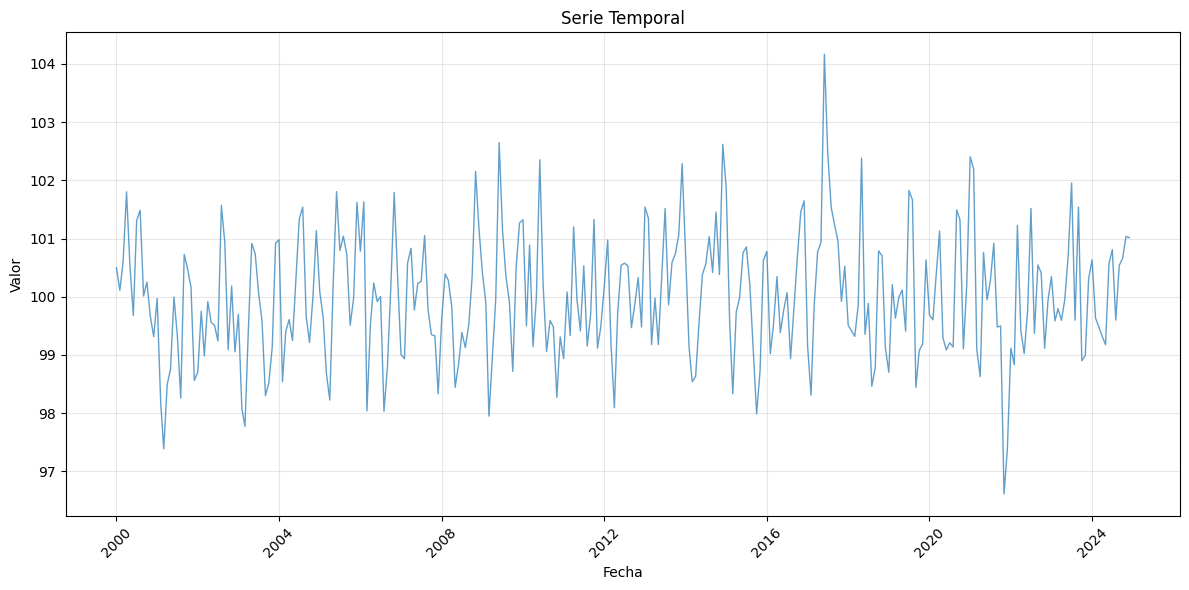

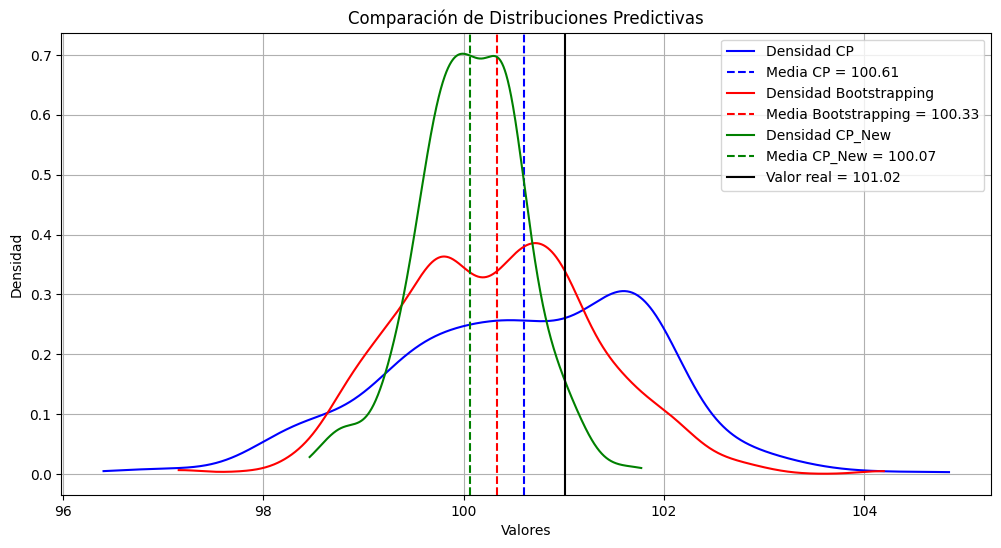


Resultados CRPS por modelo:


,modelo,crps
0,CPModel,0.355912
1,BootstrappingModel,0.412638
2,CP_NewModel,0.664650


In [7]:
def AR(random_state=42):
    """Función principal que ejecuta ambos modelos y genera visualizaciones"""
    np.random.seed(random_state)
    
    # Crear el simulador
    simulator = TimeSeriesSimulator(random_state=42)
    df = simulator.generate_ar(ar_params=[-0.5, 0.2])
    
    # ✅ Extraer el valor real directamente desde la serie simulada
    y_real = df['valor'].iloc[-1]
    
    # 1. Ajustar el modelo TimeDistributionModel
    model_td = TimeDistributionModel(random_state=random_state)
    best_params = model_td.grid_search(df)
    distribution_td, _ = model_td.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_td = model_td.calculate_crps(distribution_td, y_real)
    
    # 2. Ajustar el modelo BootstrappingModel
    model_boot = BootstrappingModel(random_state=random_state)
    best_lag = model_boot.grid_search(df)
    distribution_boot = model_boot.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_boot = model_boot.calculate_crps(distribution_boot, y_real)
    
    # 3. Ajustar el modelo CP_New
    model_cp = CPnewModel()
    best_params_cp = model_cp.bayesian_optimization(df)
    distribution_cp = model_cp.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_cp = model_cp.calculate_crps(distribution_cp, y_real)
    
    # 4. Generar visualizaciones
    plot_utils = PlotUtils(random_state=random_state)
    
    # Graficar la serie temporal original
    plot_utils.plot_time_series(df)
    
    # Graficar densidades comparativas con el mismo y_real para todos
    distributions_dict = {
        'CP': distribution_td,
        'Bootstrapping': distribution_boot,
        'CP_New': distribution_cp
    }
    plot_utils.plot_comparative_density(distributions_dict, y_real)
    
    # 5. Crear DataFrame con resultados
    results = pd.DataFrame({
        'modelo': ['CPModel', 'BootstrappingModel', 'CP_NewModel'],
        'crps': [crps_td, crps_boot, crps_cp]
    })
    
    print("\nResultados CRPS por modelo:")
    results = results.sort_values(by='crps')
    display(results)
    
    return results

AR_result = AR(random_state=227)


## Simulación MA

Mejores parámetros encontrados: n_lags = 5, rho = 0.5, CRPS = 0.2811
✅ Mejor n_lags encontrado (Bootstrapping): 1, CRPS = 0.3935
|   iter    |  target   |   alpha   |  n_lags   | poly_d... |    rho    |
-------------------------------------------------------------------------
| 1         | -1e+06    | 0.3746    | 11.46     | 2.464     | 0.9137    |
| 2         | -1e+06    | 0.1561    | 2.716     | 1.116     | 0.9646    |
| 3         | -1e+06    | 0.6012    | 8.789     | 1.041     | 0.9843    |
| 4         | -1e+06    | 0.8325    | 3.336     | 1.364     | 0.8348    |
| 5         | -1e+06    | 0.3043    | 6.772     | 1.864     | 0.8553    |
| 6         | -1e+06    | 0.2016    | 1.007     | 2.927     | 0.8838    |
| 7         | -1e+06    | 0.268     | 11.99     | 2.95      | 0.9035    |
| 8         | -1e+06    | 0.6       | 1.022     | 2.994     | 0.8817    |
| 9         | -1e+06    | 0.8594    | 12.0      | 2.972     | 0.9618    |
| 10        | -1e+06    | 0.8398    | 1.016     | 1.04   

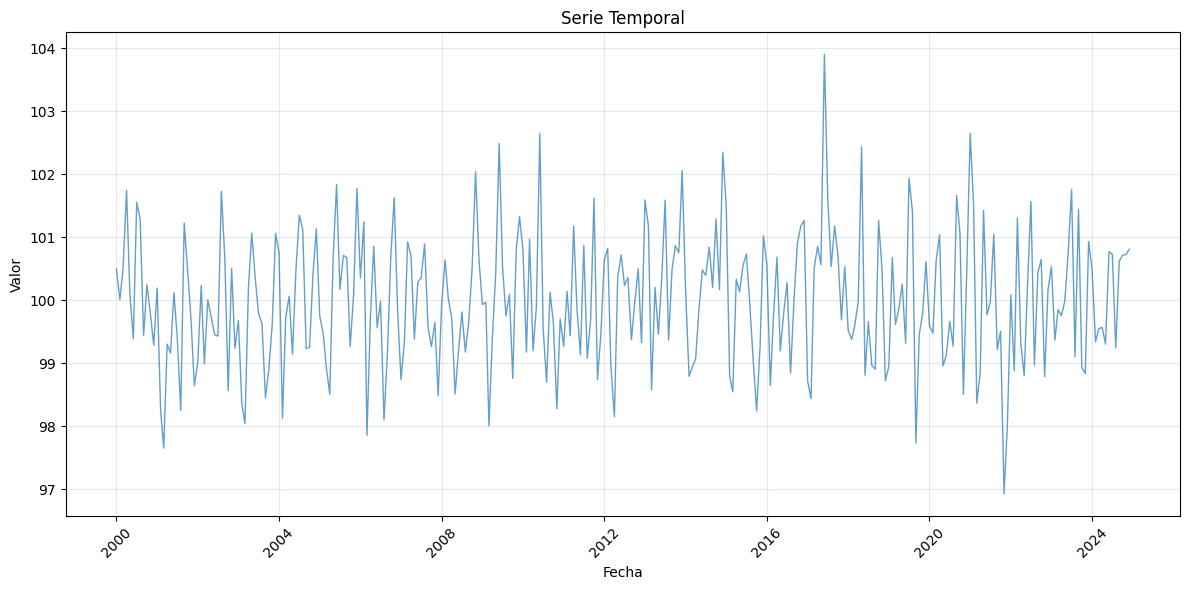

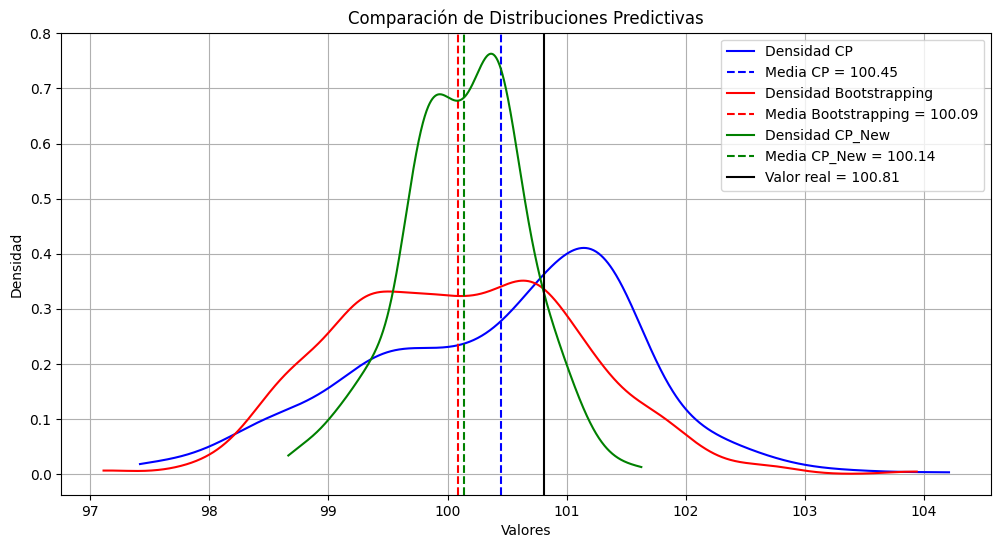


Resultados CRPS por modelo:


,modelo,crps
0,CPModel,0.281110
2,CP_NewModel,0.425137
1,BootstrappingModel,0.431833


In [8]:

def MA(random_state=42):
    """Función principal que ejecuta ambos modelos y genera visualizaciones"""
    np.random.seed(random_state)
    
    # Crear el simulador
    simulator = TimeSeriesSimulator(random_state=42)
    df = simulator.generate_ma(ma_params=[0.3, -0.2])
    
    # ✅ Extraer el valor real directamente desde la serie simulada
    y_real = df['valor'].iloc[-1]
    
    # 1. Ajustar el modelo TimeDistributionModel
    model_td = TimeDistributionModel(random_state=random_state)
    best_params = model_td.grid_search(df)
    distribution_td, _ = model_td.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_td = model_td.calculate_crps(distribution_td, y_real)
    
    # 2. Ajustar el modelo BootstrappingModel
    model_boot = BootstrappingModel(random_state=random_state)
    best_lag = model_boot.grid_search(df)
    distribution_boot = model_boot.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_boot = model_boot.calculate_crps(distribution_boot, y_real)
    
    # 3. Ajustar el modelo CP_New
    model_cp = CPnewModel()
    best_params_cp = model_cp.bayesian_optimization(df)
    distribution_cp = model_cp.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_cp = model_cp.calculate_crps(distribution_cp, y_real)
    
    # 4. Generar visualizaciones
    plot_utils = PlotUtils(random_state=random_state)
    
    # Graficar la serie temporal original
    plot_utils.plot_time_series(df)
    
    # Graficar densidades comparativas con el mismo y_real para todos
    distributions_dict = {
        'CP': distribution_td,
        'Bootstrapping': distribution_boot,
        'CP_New': distribution_cp
    }
    plot_utils.plot_comparative_density(distributions_dict, y_real)
    
    # 5. Crear DataFrame con resultados
    results = pd.DataFrame({
        'modelo': ['CPModel', 'BootstrappingModel', 'CP_NewModel'],
        'crps': [crps_td, crps_boot, crps_cp]
    })
    
    print("\nResultados CRPS por modelo:")
    results = results.sort_values(by='crps')
    display(results)
    
    return results

MA_result = MA(random_state=227)

## Simulación ARIMA

✅ Mejores parámetros encontrados: n_lags = 3, rho = 0.5, CRPS = 0.5395
✅ Mejor n_lags encontrado (Bootstrapping): 6, CRPS = 0.7117
|   iter    |  target   |   alpha   |  n_lags   | poly_d... |    rho    |
-------------------------------------------------------------------------
| 1         | -1e+06    | 0.3746    | 11.46     | 2.464     | 0.9137    |
| 2         | -1e+06    | 0.1561    | 2.716     | 1.116     | 0.9646    |
| 3         | -1e+06    | 0.6012    | 8.789     | 1.041     | 0.9843    |
| 4         | -1e+06    | 0.8325    | 3.336     | 1.364     | 0.8348    |
| 5         | -1e+06    | 0.3043    | 6.772     | 1.864     | 0.8553    |
| 6         | -1e+06    | 0.2016    | 1.007     | 2.927     | 0.8838    |
| 7         | -1e+06    | 0.268     | 11.99     | 2.95      | 0.9035    |
| 8         | -1e+06    | 0.6       | 1.022     | 2.994     | 0.8817    |
| 9         | -1e+06    | 0.8594    | 12.0      | 2.972     | 0.9618    |
| 10        | -1e+06    | 0.8398    | 1.016     | 1.04 

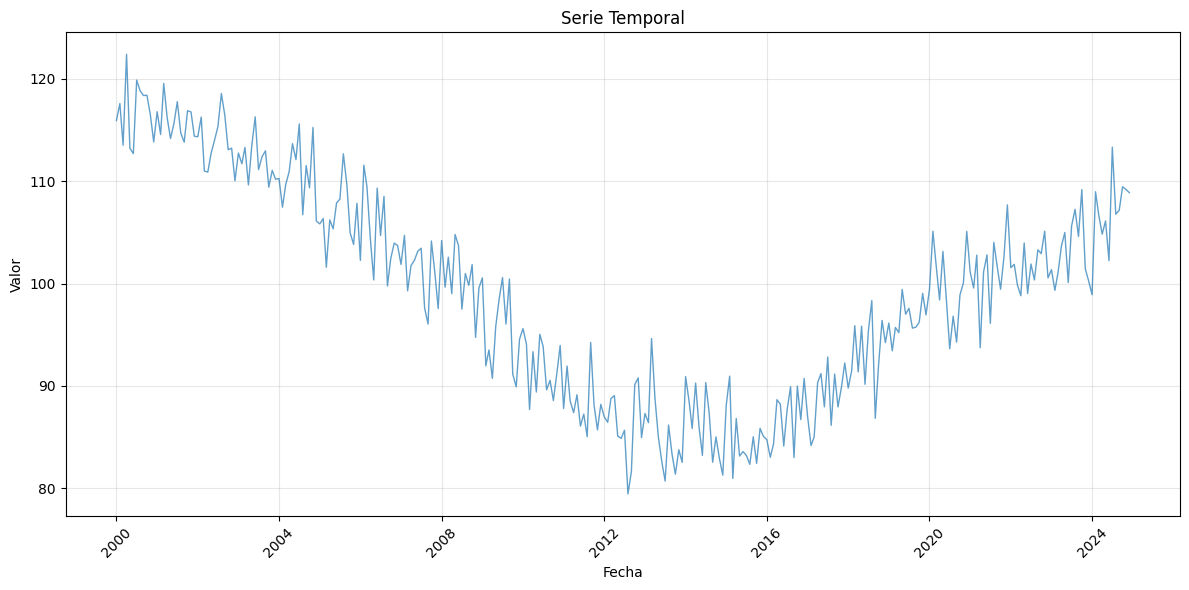

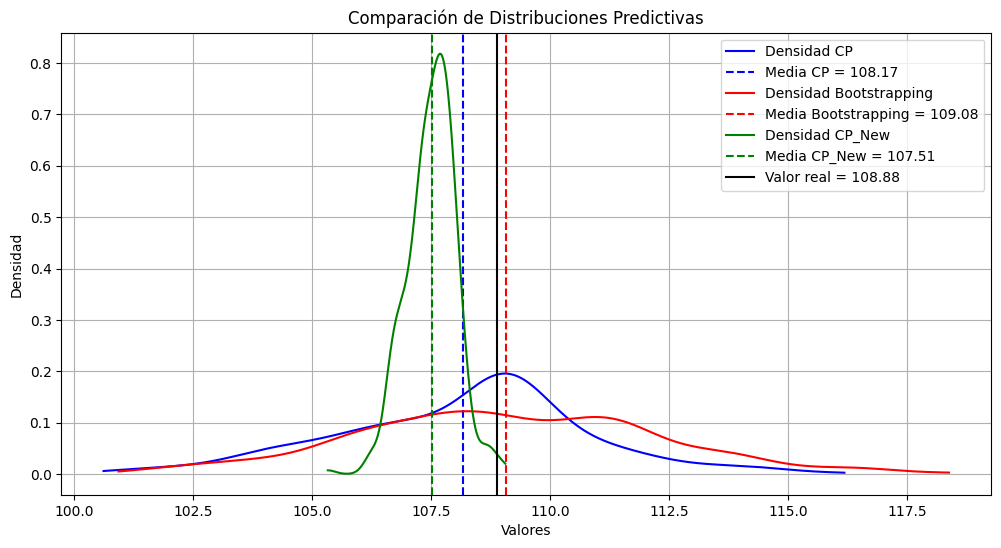


Resultados CRPS por modelo:


,modelo,crps
0,CPModel,0.539544
1,BootstrappingModel,0.753777
2,CP_NewModel,1.097182


In [18]:

def ARIMA(random_state=42):
    """Función principal que ejecuta ambos modelos y genera visualizaciones"""
    np.random.seed(random_state)
    
    # Crear el simulador
    simulator = TimeSeriesSimulator(random_state=random_state)
    df = simulator.generate_arima(
        n_points=300,
        ar_params=[-0.5],    # AR(1)
        ma_params=[0.5],     # MA(1)
        d=2,                 # Integración de orden 2
        mean=100,
        std=10,             # Variabilidad base
        noise_level=0.3     # Nivel de ruido adicional (30% de std)
    )
    
    
    # ✅ Extraer el valor real directamente desde la serie simulada
    y_real = df['valor'].iloc[-1]
    
    # 1. Ajustar el modelo TimeDistributionModel
    model_td = TimeDistributionModel(random_state=random_state)
    best_params = model_td.grid_search(df)
    distribution_td = model_td.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_td = model_td.calculate_crps(distribution_td, y_real)
    
    # 2. Ajustar el modelo BootstrappingModel
    model_boot = BootstrappingModel(random_state=random_state)
    best_lag = model_boot.grid_search(df)
    distribution_boot = model_boot.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_boot = model_boot.calculate_crps(distribution_boot, y_real)
    
    # 3. Ajustar el modelo CP_New
    model_cp = CPnewModel()
    best_params_cp = model_cp.bayesian_optimization(df)
    distribution_cp = model_cp.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_cp = model_cp.calculate_crps(distribution_cp, y_real)
    
    # 4. Generar visualizaciones
    plot_utils = PlotUtils(random_state=random_state)
    
    # Graficar la serie temporal original
    plot_utils.plot_time_series(df)
    
    # Graficar densidades comparativas con el mismo y_real para todos
    distributions_dict = {
        'CP': distribution_td,
        'Bootstrapping': distribution_boot,
        'CP_New': distribution_cp
    }
    plot_utils.plot_comparative_density(distributions_dict, y_real)
    
    # 5. Crear DataFrame con resultados
    results = pd.DataFrame({
        'modelo': ['CPModel', 'BootstrappingModel', 'CP_NewModel'],
        'crps': [crps_td, crps_boot, crps_cp]
    })
    
    print("\nResultados CRPS por modelo:")
    results = results.sort_values(by='crps')
    display(results)
    
    return results

ARIMA_result = ARIMA(random_state=42)

## Trend

✅ Mejores parámetros encontrados: n_lags = 2, rho = 0.5, CRPS = 11.6575
✅ Mejor n_lags encontrado (Bootstrapping): 3, CRPS = 31.1915
|   iter    |  target   |   alpha   |  n_lags   | poly_d... |    rho    |
-------------------------------------------------------------------------
| 1         | -1e+06    | 0.3746    | 11.46     | 2.464     | 0.9137    |
| 2         | -1e+06    | 0.1561    | 2.716     | 1.116     | 0.9646    |
| 3         | -1e+06    | 0.6012    | 8.789     | 1.041     | 0.9843    |
| 4         | -1e+06    | 0.8325    | 3.336     | 1.364     | 0.8348    |
| 5         | -1e+06    | 0.3043    | 6.772     | 1.864     | 0.8553    |
| 6         | -1e+06    | 0.2016    | 1.007     | 2.927     | 0.8838    |
| 7         | -1e+06    | 0.268     | 11.99     | 2.95      | 0.9035    |
| 8         | -1e+06    | 0.6       | 1.022     | 2.994     | 0.8817    |
| 9         | -1e+06    | 0.8594    | 12.0      | 2.972     | 0.9618    |
| 10        | -1e+06    | 0.8398    | 1.016     | 1.0

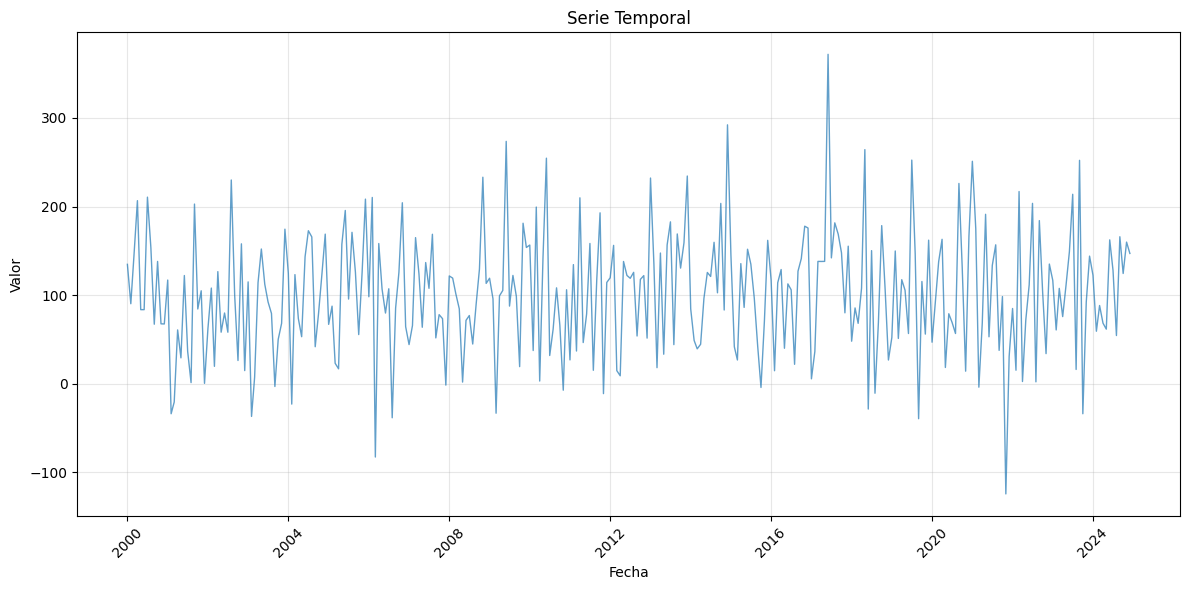

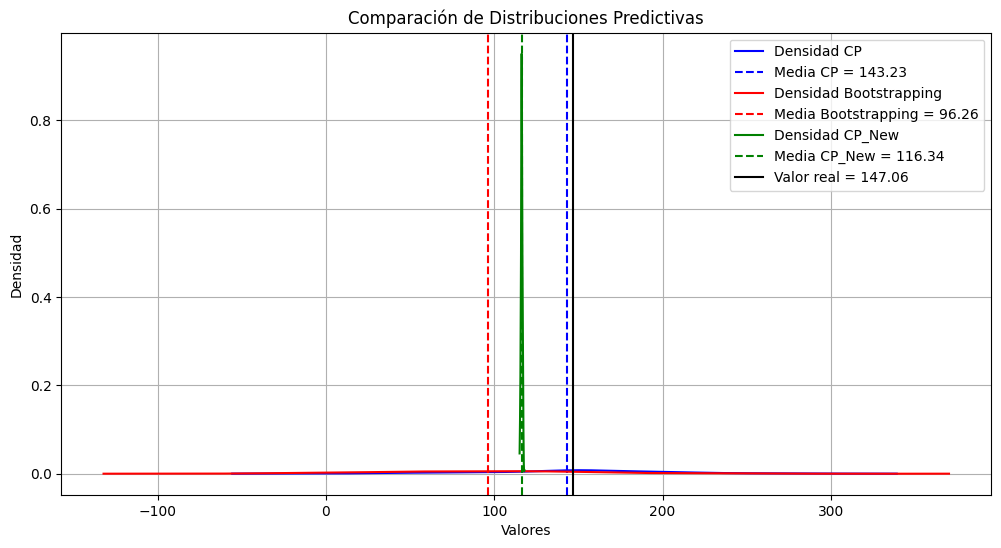


Resultados CRPS por modelo:


,modelo,crps
0,CPModel,11.657509
2,CP_NewModel,30.463541
1,BootstrappingModel,31.250824


In [25]:
import numpy as np
import pandas as pd
from scipy import stats


def trend(random_state=42):
    """Función principal que ejecuta ambos modelos y genera visualizaciones"""
    np.random.seed(random_state)
    
    # Crear el simulador
    simulator = TimeSeriesSimulator(random_state=random_state)
    df = simulator.generate_trend(trend_type='linear', slope=0.01)
    
    # ✅ Extraer el valor real directamente desde la serie simulada
    y_real = df['valor'].iloc[-1]
    
    # 1. Ajustar el modelo TimeDistributionModel
    model_td = TimeDistributionModel(random_state=random_state)
    best_params = model_td.grid_search(df)
    distribution_td = model_td.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_td = model_td.calculate_crps(distribution_td, y_real)
    
    # 2. Ajustar el modelo BootstrappingModel
    model_boot = BootstrappingModel(random_state=random_state)
    best_lag = model_boot.grid_search(df)
    distribution_boot = model_boot.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_boot = model_boot.calculate_crps(distribution_boot, y_real)
    
    # 3. Ajustar el modelo CP_New
    model_cp = CPnewModel()
    best_params_cp = model_cp.bayesian_optimization(df)
    distribution_cp = model_cp.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_cp = model_cp.calculate_crps(distribution_cp, y_real)
    
    # 4. Generar visualizaciones
    plot_utils = PlotUtils(random_state=random_state)
    
    # Graficar la serie temporal original
    plot_utils.plot_time_series(df)
    
    # Graficar densidades comparativas con el mismo y_real para todos
    distributions_dict = {
        'CP': distribution_td,
        'Bootstrapping': distribution_boot,
        'CP_New': distribution_cp
    }
    plot_utils.plot_comparative_density(distributions_dict, y_real)
    
    # 5. Crear DataFrame con resultados
    results = pd.DataFrame({
        'modelo': ['CPModel', 'BootstrappingModel', 'CP_NewModel'],
        'crps': [crps_td, crps_boot, crps_cp]
    })
    
    print("\nResultados CRPS por modelo:")
    results = results.sort_values(by='crps')
    display(results)
    
    return results

# Ejecutar la función principal
trend_result = trend(random_state=42)


✅ Mejores parámetros encontrados: n_lags = 2, rho = 0.5, CRPS = 0.1665
✅ Mejor n_lags encontrado (Bootstrapping): 1, CRPS = 2.4669
|   iter    |  target   |   alpha   |  n_lags   | poly_d... |    rho    |
-------------------------------------------------------------------------
| 1         | -1e+06    | 0.3746    | 11.46     | 2.464     | 0.9137    |
| 2         | -1e+06    | 0.1561    | 2.716     | 1.116     | 0.9646    |
| 3         | -1e+06    | 0.6012    | 8.789     | 1.041     | 0.9843    |
| 4         | -1e+06    | 0.8325    | 3.336     | 1.364     | 0.8348    |
| 5         | -1e+06    | 0.3043    | 6.772     | 1.864     | 0.8553    |
| 6         | -1e+06    | 0.2016    | 1.007     | 2.927     | 0.8838    |
| 7         | -1e+06    | 0.268     | 11.99     | 2.95      | 0.9035    |
| 8         | -1e+06    | 0.6       | 1.022     | 2.994     | 0.8817    |
| 9         | -1e+06    | 0.8594    | 12.0      | 2.972     | 0.9618    |
| 10        | -1e+06    | 0.8398    | 1.016     | 1.04 

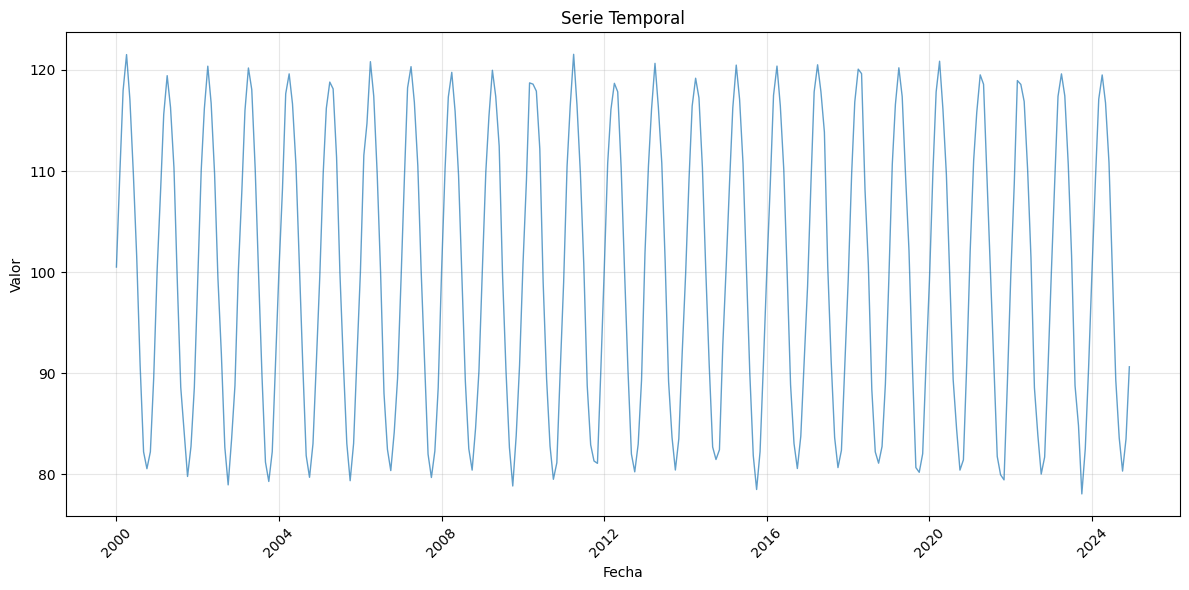

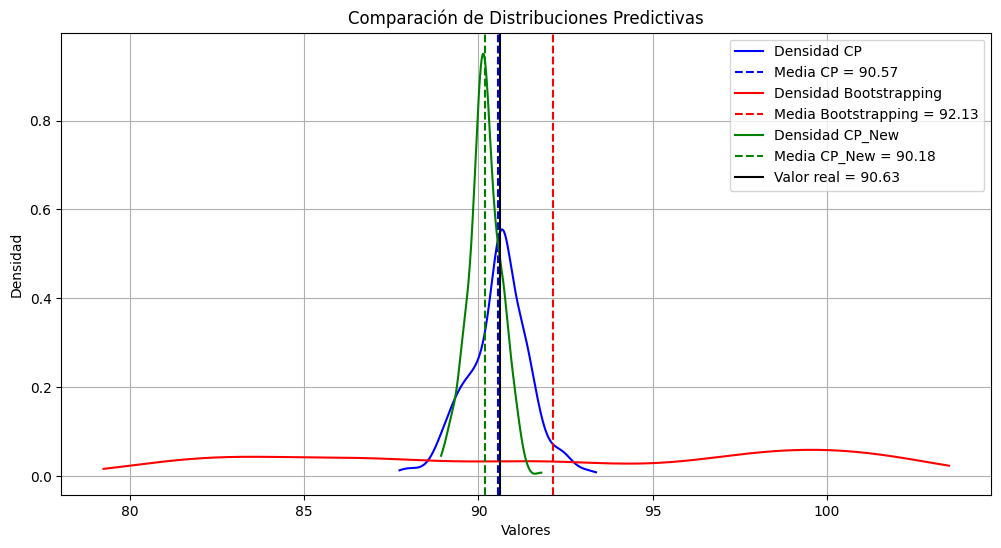


Resultados CRPS por modelo:


,modelo,crps
0,CPModel,0.166536
2,CP_NewModel,0.275480
1,BootstrappingModel,2.422166


In [21]:

def seasonal(random_state=42):
    """Función principal que ejecuta ambos modelos y genera visualizaciones"""
    np.random.seed(random_state)
    
    # Crear el simulador
    simulator = TimeSeriesSimulator(random_state=random_state)
    df = simulator.generate_seasonal(period=12, amplitude=20)
    
    # ✅ Extraer el valor real directamente desde la serie simulada
    y_real = df['valor'].iloc[-1]
    
    # 1. Ajustar el modelo TimeDistributionModel
    model_td = TimeDistributionModel(random_state=random_state)
    best_params = model_td.grid_search(df)
    distribution_td = model_td.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_td = model_td.calculate_crps(distribution_td, y_real)
    
    # 2. Ajustar el modelo BootstrappingModel
    model_boot = BootstrappingModel(random_state=random_state)
    best_lag = model_boot.grid_search(df)
    distribution_boot = model_boot.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_boot = model_boot.calculate_crps(distribution_boot, y_real)
    
    # 3. Ajustar el modelo CP_New
    model_cp = CPnewModel()
    best_params_cp = model_cp.bayesian_optimization(df)
    distribution_cp = model_cp.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_cp = model_cp.calculate_crps(distribution_cp, y_real)
    
    # 4. Generar visualizaciones
    plot_utils = PlotUtils(random_state=random_state)
    
    # Graficar la serie temporal original
    plot_utils.plot_time_series(df)
    
    # Graficar densidades comparativas con el mismo y_real para todos
    distributions_dict = {
        'CP': distribution_td,
        'Bootstrapping': distribution_boot,
        'CP_New': distribution_cp
    }
    plot_utils.plot_comparative_density(distributions_dict, y_real)
    
    # 5. Crear DataFrame con resultados
    results = pd.DataFrame({
        'modelo': ['CPModel', 'BootstrappingModel', 'CP_NewModel'],
        'crps': [crps_td, crps_boot, crps_cp]
    })
    
    print("\nResultados CRPS por modelo:")
    results = results.sort_values(by='crps')
    display(results)
    
    return results

seasonal_result = seasonal(random_state=42)

Mejores parámetros encontrados: n_lags = 2, rho = 0.5, CRPS = 5.3734
✅ Mejor n_lags encontrado (Bootstrapping): 1, CRPS = 1.7816
|   iter    |  target   |   alpha   |  n_lags   | poly_d... |    rho    |
-------------------------------------------------------------------------
| 1         | -1e+06    | 0.3746    | 11.46     | 2.464     | 0.9137    |
| 2         | -1e+06    | 0.1561    | 2.716     | 1.116     | 0.9646    |
| 3         | -1e+06    | 0.6012    | 8.789     | 1.041     | 0.9843    |
| 4         | -1e+06    | 0.8325    | 3.336     | 1.364     | 0.8348    |
| 5         | -1e+06    | 0.3043    | 6.772     | 1.864     | 0.8553    |
| 6         | -1e+06    | 0.2016    | 1.007     | 2.927     | 0.8838    |
| 7         | -1e+06    | 0.268     | 11.99     | 2.95      | 0.9035    |
| 8         | -1e+06    | 0.6       | 1.022     | 2.994     | 0.8817    |
| 9         | -1e+06    | 0.8594    | 12.0      | 2.972     | 0.9618    |
| 10        | -1e+06    | 0.8398    | 1.016     | 1.04   

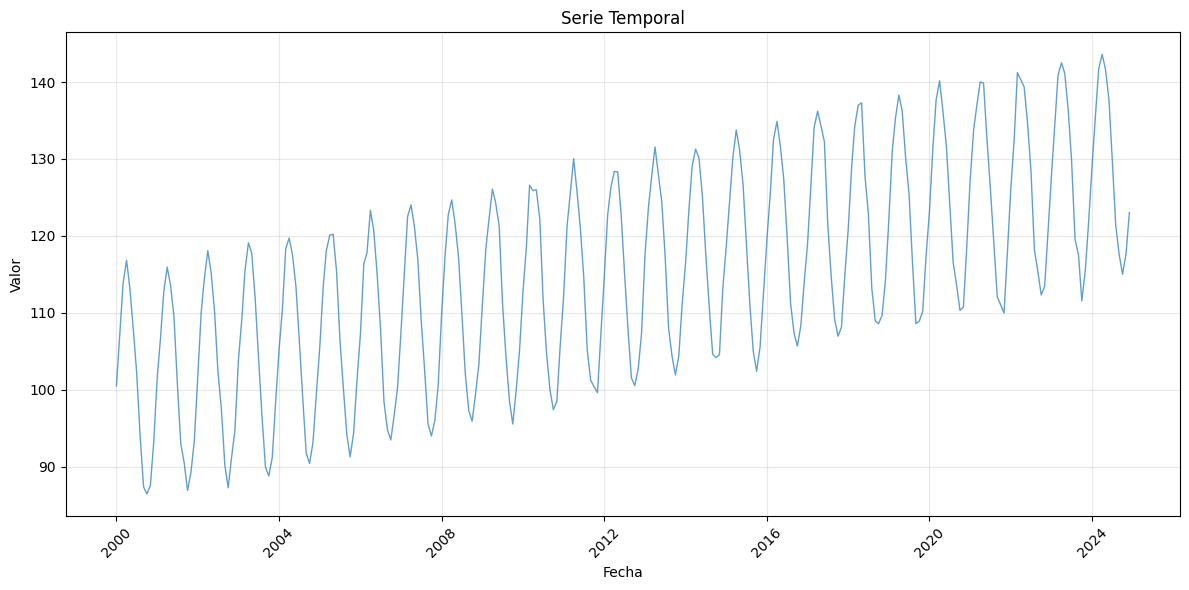

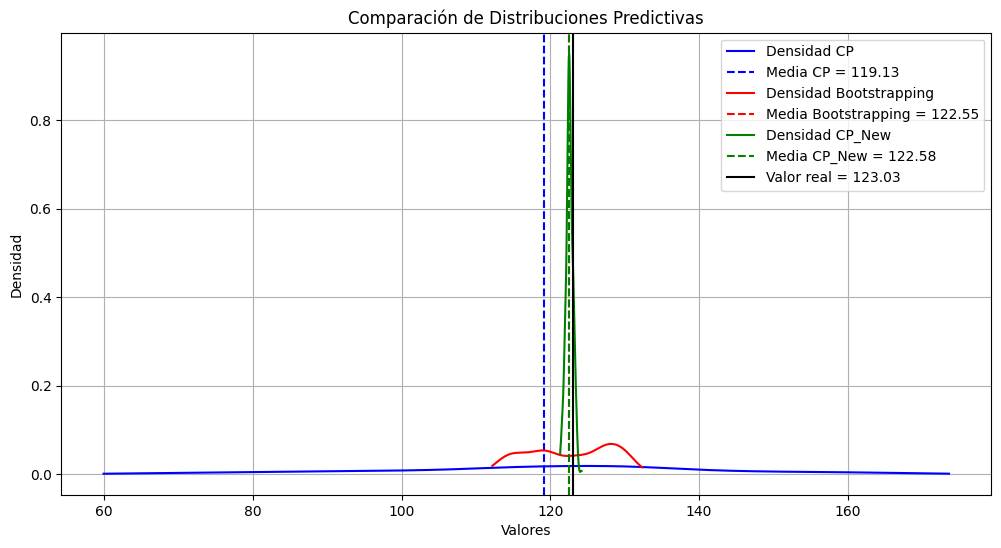


Resultados CRPS por modelo:


,modelo,crps
2,CP_NewModel,0.275480
1,BootstrappingModel,1.737277
0,CPModel,5.373439


In [12]:

def trend_seasonal(random_state=42):
    """Función principal que ejecuta ambos modelos y genera visualizaciones"""
    np.random.seed(random_state)
    
    # Crear el simulador
    simulator = TimeSeriesSimulator(random_state=42)
    df = simulator.generate_trend_seasonal(slope=0.1, amplitude=15)
    
    # ✅ Extraer el valor real directamente desde la serie simulada
    y_real = df['valor'].iloc[-1]
    
    # 1. Ajustar el modelo TimeDistributionModel
    model_td = TimeDistributionModel(random_state=random_state)
    best_params = model_td.grid_search(df)
    distribution_td = model_td.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_td = model_td.calculate_crps(distribution_td, y_real)
    
    # 2. Ajustar el modelo BootstrappingModel
    model_boot = BootstrappingModel(random_state=random_state)
    best_lag = model_boot.grid_search(df)
    distribution_boot = model_boot.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_boot = model_boot.calculate_crps(distribution_boot, y_real)
    
    # 3. Ajustar el modelo CP_New
    model_cp = CPnewModel()
    best_params_cp = model_cp.bayesian_optimization(df)
    distribution_cp = model_cp.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_cp = model_cp.calculate_crps(distribution_cp, y_real)
    
    # 4. Generar visualizaciones
    plot_utils = PlotUtils(random_state=random_state)
    
    # Graficar la serie temporal original
    plot_utils.plot_time_series(df)
    
    # Graficar densidades comparativas con el mismo y_real para todos
    distributions_dict = {
        'CP': distribution_td,
        'Bootstrapping': distribution_boot,
        'CP_New': distribution_cp
    }
    plot_utils.plot_comparative_density(distributions_dict, y_real)
    
    # 5. Crear DataFrame con resultados
    results = pd.DataFrame({
        'modelo': ['CPModel', 'BootstrappingModel', 'CP_NewModel'],
        'crps': [crps_td, crps_boot, crps_cp]
    })
    
    print("\nResultados CRPS por modelo:")
    results = results.sort_values(by='crps')
    display(results)
    
    return results
trend_seasonal_result = trend_seasonal(random_state=42)

# Datos Reales 

✅ Mejores parámetros encontrados: n_lags = 4, rho = 0.99, CRPS = 1.0135
✅ Mejor n_lags encontrado (Bootstrapping): 2, CRPS = 1.0684
|   iter    |  target   |   alpha   |  n_lags   | poly_d... |    rho    |
-------------------------------------------------------------------------
| 1         | -1e+06    | 0.3746    | 11.46     | 2.464     | 0.9137    |
| 2         | -1e+06    | 0.1561    | 2.716     | 1.116     | 0.9646    |
| 3         | -1e+06    | 0.6012    | 8.789     | 1.041     | 0.9843    |
| 4         | -1e+06    | 0.8325    | 3.336     | 1.364     | 0.8348    |
| 5         | -1e+06    | 0.3043    | 6.772     | 1.864     | 0.8553    |
| 6         | -1e+06    | 0.2016    | 1.007     | 2.927     | 0.8838    |
| 7         | -1e+06    | 0.268     | 11.99     | 2.95      | 0.9035    |
| 8         | -1e+06    | 0.6       | 1.022     | 2.994     | 0.8817    |
| 9         | -1e+06    | 0.8594    | 12.0      | 2.972     | 0.9618    |
| 10        | -1e+06    | 0.8398    | 1.016     | 1.04

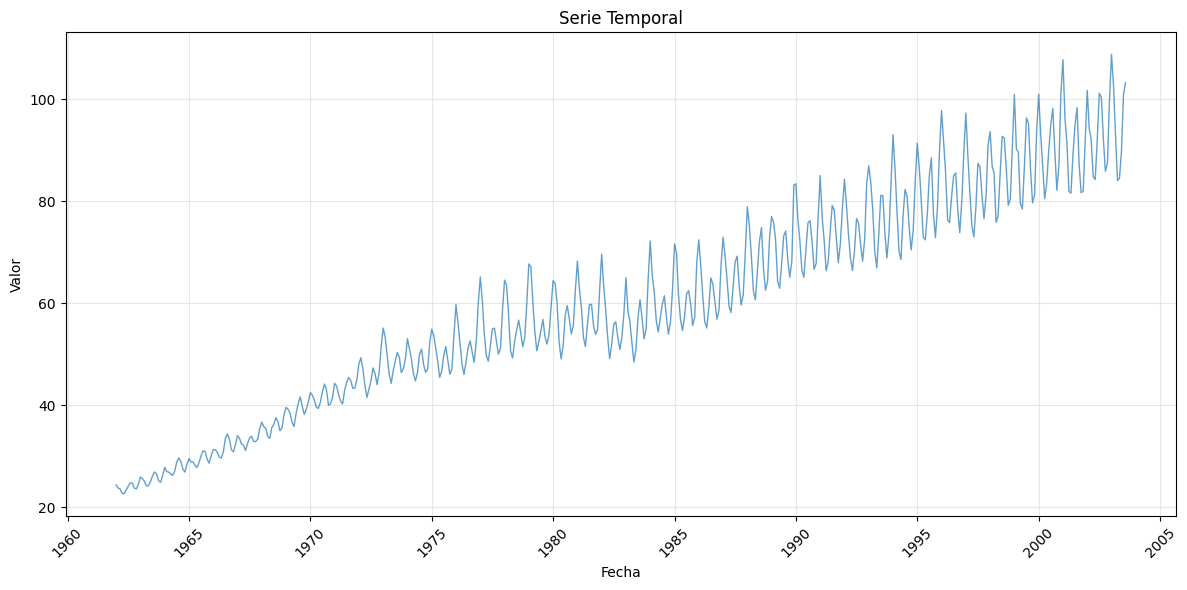

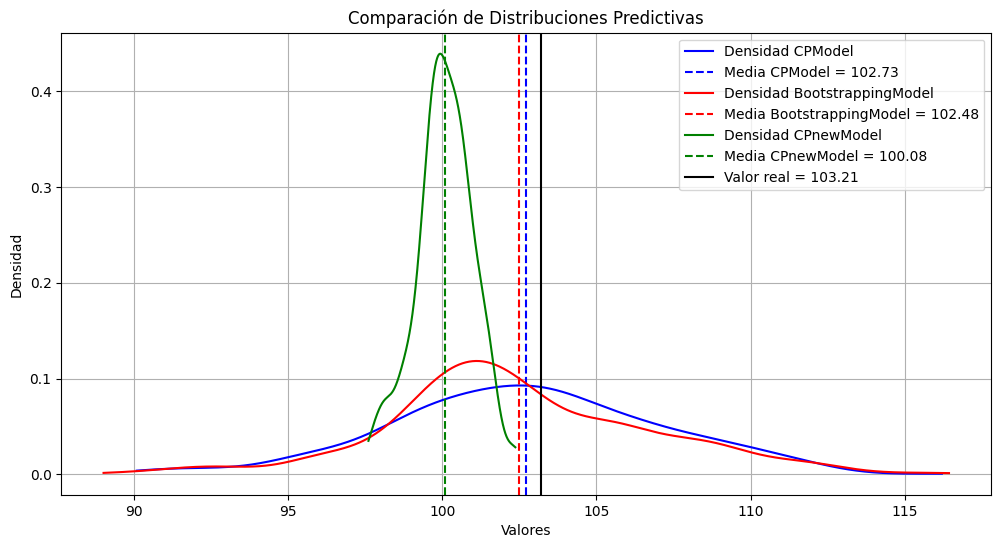


📊 Resultados CRPS por modelo:


,modelo,crps
0,CPModel,1.013503
1,BootstrappingModel,1.074131
2,CPnewModel,2.595495


In [22]:
import pandas as pd
import numpy as np

def datos_IPG(random_state=42):
    # ✅ Carga y preprocesamiento de datos
    df = pd.read_csv("../../../data/IPG2211A2N.csv", usecols=['DATE', 'IPG2211A2N'], nrows=500, parse_dates=['DATE'])
    df = df.rename(columns={'DATE': 'fecha', 'IPG2211A2N': 'valor'})
    df = df.dropna(subset=['valor']).reset_index(drop=True)
    df['fecha'] = pd.date_range(start=df['fecha'].min(), periods=len(df), freq='MS')
    
    # ✅ Extraer el valor real directamente desde la serie simulada
    y_real = df['valor'].iloc[-1]
    
    # 1️⃣ Ajustar el modelo TimeDistributionModel
    model_td = TimeDistributionModel(random_state=random_state)
    best_params = model_td.grid_search(df)
    distribution_td = model_td.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_td = model_td.calculate_crps(distribution_td, y_real)
    
    # 2️⃣ Ajustar el modelo BootstrappingModel
    model_boot = BootstrappingModel(random_state=random_state)
    best_lag = model_boot.grid_search(df)
    distribution_boot = model_boot.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_boot = model_boot.calculate_crps(distribution_boot, y_real)
    
    # 3️⃣ Ajustar el modelo CPnewModel
    model_cp = CPnewModel()
    best_params_cp = model_cp.bayesian_optimization(df)
    distribution_cp = model_cp.fit_predict(df)  # Ignorar y_real calculado internamente
    crps_cp = model_cp.calculate_crps(distribution_cp, y_real)
    
    # 4️⃣ Generar visualizaciones
    plot_utils = PlotUtils(random_state=random_state)
    
    # 📈 Graficar la serie temporal original
    plot_utils.plot_time_series(df)
    
    # 📊 Graficar densidades comparativas con el mismo y_real para todos
    distributions_dict = {
        'CPModel': distribution_td,
        'BootstrappingModel': distribution_boot,
        'CPnewModel': distribution_cp
    }
    plot_utils.plot_comparative_density(distributions_dict, y_real)
    
    # 5️⃣ Crear DataFrame con resultados
    results = pd.DataFrame({
        'modelo': ['CPModel', 'BootstrappingModel', 'CPnewModel'],
        'crps': [crps_td, crps_boot, crps_cp]
    })
    
    print("\n📊 Resultados CRPS por modelo:")
    results = results.sort_values(by='crps')
    display(results)
    
    return results

# 🚀 Ejecutar la función
datos_IPG_result = datos_IPG(random_state=42)
